In [79]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import statsmodels.formula.api as smf

In [55]:
cancun_variables = pd.read_csv('../data/processed/cancun_variables.csv')

In [56]:
features = cancun_variables.drop(columns=['currency', 'url',])

In [57]:
features.shape

(6669, 16)

In [58]:
features.head(3)

,accuracy,avg_rating,checkin,cleanliness,communication,guest_satisfication,host_reviews,location,monthly_price_factor,picture_count,price,response_rate,reviews_count,value,weekly_price_factor,listing_key
0,10,4.74,10,9,10,95,311,10,0.88,19,22,100,50,10,0.88,20776319
1,10,4.93,10,10,10,99,147,10,0.85,22,28,100,108,10,0.90,16492050
2,10,4.72,10,9,10,94,1376,9,1.00,14,30,100,243,9,1.00,14266451


In [59]:
features.avg_rating.describe()

count    6669.000000
mean        3.148048
std         2.235194
min         0.000000
25%         0.000000
50%         4.600000
75%         4.890000
max         5.000000
Name: avg_rating, dtype: float64

In [60]:
features.guest_satisfication.describe()

count    6669.000000
mean       62.889639
std        44.739948
min         0.000000
25%         0.000000
50%        92.000000
75%        98.000000
max       100.000000
Name: guest_satisfication, dtype: float64

In [61]:
# I ended up choosing guest_satisfication as my main rating metric

In [62]:
# avg_rating and guest_satisfication have 99.7% correlation. 
# cleanliness, accuracy, communication, location, checkin, and value are all >95% correlated woth
# guest satisfication. I made the decision to remove them as that much correlation would not
# be any additional information added.

# It seems that avg_rating = guest_satisfication / 20 pretty much
features.corr().head()

,accuracy,avg_rating,checkin,cleanliness,communication,guest_satisfication,host_reviews,location,monthly_price_factor,picture_count,price,response_rate,reviews_count,value,weekly_price_factor,listing_key
accuracy,1.000000,0.992309,0.990886,0.990295,0.991176,0.994652,0.177921,0.987020,-0.139480,0.193348,-0.359434,0.369317,0.362316,0.992261,-0.092889,-0.329599
avg_rating,0.992309,1.000000,0.989050,0.990579,0.989837,0.997632,0.172307,0.985834,-0.140742,0.193397,-0.354868,0.365996,0.354550,0.992373,-0.093601,-0.327416
checkin,0.990886,0.989050,1.000000,0.988552,0.993897,0.991113,0.179253,0.988432,-0.143273,0.192724,-0.362077,0.368950,0.359717,0.989198,-0.095179,-0.331756
cleanliness,0.990295,0.990579,0.988552,1.000000,0.988507,0.992760,0.171952,0.985116,-0.138918,0.193025,-0.355318,0.366982,0.355402,0.991006,-0.092434,-0.328079
communication,0.991176,0.989837,0.993897,0.988507,1.000000,0.992177,0.175797,0.988185,-0.144677,0.193033,-0.361562,0.369345,0.359842,0.990224,-0.097071,-0.331289


In [63]:
filtered_features = features.drop(columns=['accuracy', 'checkin', 'cleanliness', 'communication',
                                           'location', 'value', 'avg_rating'])

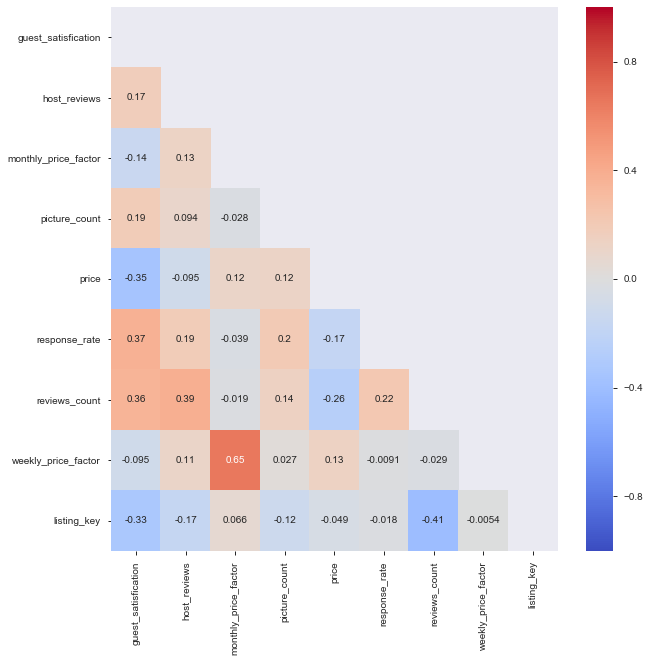

In [74]:
filtered_features_corr = filtered_features.corr()

# Filter out correlations <0.20 to make graph easier to read
# filtered_features_corr[np.abs(filtered_features_corr)<.2] = 0

# Create mask to only include half of matrix
mask = np.zeros_like(filtered_features_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,10))
sns.heatmap(filtered_features_corr,
            vmin=-1,
            vmax=1,
            cmap='coolwarm',
            annot=True,
            mask=mask);

In [76]:
# This looks much better now
# There still seems to be high correlation between weekly_price_factor and monthly_price_factor
# but we can start working on feature importance right now.

In [77]:
filtered_features.shape

(6669, 9)

In [73]:
# Response is guest satisfication and let's see if we can rank feature importance.

In [81]:
filtered_features.columns

Index(['guest_satisfication', 'host_reviews', 'monthly_price_factor',
       'picture_count', 'price', 'response_rate', 'reviews_count',
       'weekly_price_factor', 'listing_key'],
      dtype='object')

In [86]:
# Quick linear regression

model = smf.ols(formula="guest_satisfication ~ host_reviews + monthly_price_factor + \
                         picture_count + response_rate + reviews_count + weekly_price_factor"
                         , data=filtered_features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     guest_satisfication   R-squared:                       0.238
Model:                             OLS   Adj. R-squared:                  0.237
Method:                  Least Squares   F-statistic:                     347.0
Date:                 Sun, 21 Jul 2019   Prob (F-statistic):               0.00
Time:                         16:17:28   Log-Likelihood:                -33904.
No. Observations:                 6669   AIC:                         6.782e+04
Df Residuals:                     6662   BIC:                         6.787e+04
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               68.7742      7.532      9.131      0.000      54.009      83.539
host_reviews             0.0021      0.001      1.881      0.060   -8.99e-05       0.004
monthly_price_factor   -37.6838      4.593     -8.205      0.000     -46.687     -28.681
picture_count            0.2554      0.030      8.417      0.000       0.196       0.315
response_rate            0.3170      0.013     24.984      0.000       0.292       0.342
reviews_count            0.2984      0.013     22.672      0.000       0.273       0.324
weekly_price_factor     -9.8256      9.887     -0.994      0.320     -29.207       9.556
==============================================================================
Omnibus:                     1152.813   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              444.601
Skew:                          -0.439   Prob(JB):                     2.86e-97
Kurtosis:                       2.090   Cond. No.                     1.30e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
# I don't think price should be a variable. It's mre of a filter to me

In [87]:
# TODO: scikit-learn for feature importance ranking.

In [21]:
# To possibly think of: scraping reviews to score on sentiment/positive value